**Load Dependencies**


In [1]:
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split
from cnn import CNN
from tensorflow.keras.optimizers import Adam
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Dense
from tensorflow.keras.layers import Flatten


Num GPUs Available:  1


**Load Marsyas MFCC Dataset**


In [2]:
file_path = "data/mfcc_gtzan10.json"

with open(file_path, "r") as f:
    data = json.load(f)

**Transforms Labels and MFCCs to Numpy Arrays**

In [8]:
X = np.array(data['mfcc'])
y = np.array(data['labels'])
len(X)


9996

**Split Data Set Into Training, Validation and Testing Sets**


In [11]:
TEST_SIZE = 0.25
VALIDATION_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
# Subdivide Training Set Into Validation and Training Set 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)


X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]



5997
1500
2499


In [14]:
print(X_train.shape)
print(X_train.shape[1])
print(X_train.shape[2])

(5997, 130, 13, 1)
130
13


**Construct CNN** 

In [63]:


input_shape = (X_train.shape[1], X_train.shape[2],1)
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
#model.add(BatchNormalization())

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.3))


model.add(Conv2D(256, (1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(1, 1), strides=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

BATCH_SIZE = 10
EPOCHS = 50

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'] )

model.summary()



Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 62, 4, 64)         18496     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 31, 2, 64)         0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 30, 1, 64)         16448     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 15, 1, 64)       

**Fit Model Over Training Set**


In [64]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=([reduce_lr,early_stopping])) 


Train on 5997 samples, validate on 2499 samples
Epoch 1/50
5997/5997 [==============================] - 4s 593us/sample - loss: 2.1620 - accuracy: 0.1951 - val_loss: 1.8101 - val_accuracy: 0.3814
Epoch 2/50
5997/5997 [==============================] - 3s 473us/sample - loss: 1.7982 - accuracy: 0.3597 - val_loss: 1.5156 - val_accuracy: 0.4526
Epoch 3/50
5997/5997 [==============================] - 3s 476us/sample - loss: 1.5998 - accuracy: 0.4222 - val_loss: 1.3848 - val_accuracy: 0.4902
Epoch 4/50
5997/5997 [==============================] - 3s 475us/sample - loss: 1.5189 - accuracy: 0.4476 - val_loss: 1.3219 - val_accuracy: 0.5218
Epoch 5/50
5997/5997 [==============================] - 3s 477us/sample - loss: 1.4462 - accuracy: 0.4722 - val_loss: 1.2581 - val_accuracy: 0.5490
Epoch 6/50
5997/5997 [==============================] - 3s 480us/sample - loss: 1.3819 - accuracy: 0.5048 - val_loss: 1.2061 - val_accuracy: 0.5618
Epoch 7/50
5997/5997 [==============================] - 3s 484us

**Evaluate Model Accuracy**


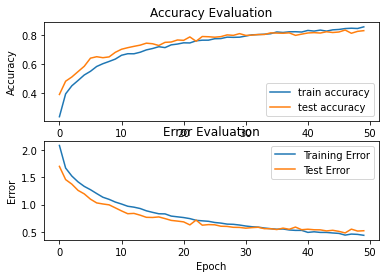

In [61]:

fig, axis = plt.subplots(2)

axis[0].plot(history.history['accuracy'], label="train accuracy")
axis[0].plot(history.history['val_accuracy'], label="test accuracy")
axis[0].set_ylabel("Accuracy")
axis[0].legend(loc="lower right")
axis[0].set_title("Accuracy Evaluation")

axis[1].plot(history.history['loss'], label="Training Error")
axis[1].plot(history.history['val_loss'], label="Test Error")
axis[1].set_ylabel("Error")
axis[1].set_xlabel("Epoch")
axis[1].legend(loc="upper right")
axis[1].set_title("Error Evaluation")

plt.show()
